# Catcher Framing

## 7.1 Introduction

This chapter analyzes catcher framing using 2022 Statcast data. Framing refers to a catcher's ability to receive pitches in a way that influences umpires to call borderline pitches as strikes.

## 7.2 Acquiring Pitch-Level Data

#### Reading data from the 2022 season:

For Statcast data, I am using the `pybaseball` library to pull data used in catcher framing analysis. This library is Python equivalent of R's `baseballr` package used in the book.

- **GitHub:** [github.com/jldbc/pybaseball](https://github.com/jldbc/pybaseball)

In [1]:
import pandas as pd
import pybaseball as pyb
from pybaseball import cache
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# pybaseball docs recommend adding cache to avoid redownloading
cache.enable()

sc2022 = pyb.statcast(start_dt='2022-03-01', end_dt='2022-11-30')

def categorize_outcome(description):
    balls = ['ball', 'blocked_ball', 'pitchout', 'hit_by_pitch']
    swings = ['swinging_strike', 'swinging_strike_blocked', 'foul', 
              'foul_bunt', 'foul_tip', 'hit_into_play', 'missed_bunt']
    if description in balls:
        return 'ball'
    elif description in swings:
        return 'swing'
    elif description == 'called_strike':
        return 'called_strike'
    else:
        return None

sc2022['Outcome'] = sc2022['description'].apply(categorize_outcome)

sc2022['Home'] = (sc2022['inning_topbot'] == 'Bot').astype(int)

sc2022['Count'] = sc2022['balls'].astype(str) + '-' + sc2022['strikes'].astype(str)

sc2022_taken = sc2022[sc2022['Outcome'] != 'swing'].copy()

print(f"Total pitches: {len(sc2022):,}")
print(f"Taken pitches: {len(sc2022_taken):,}")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [02:05<00:00,  1.96it/s]


Total pitches: 775,330
Taken pitches: 401,507


Data is filtered for only "taken" pitches (balls and called strikes) because catcher framing only affects umpire judgment on pitches the batter does not swing at.


Create 50,000 pitch sample of 2022 data and save output for analysis.  I used parquet over CSV in this case to reduce file size.  Saved to `/data` directory to use same sample if desired.

In [2]:
taken = sc2022_taken.sample(n=50000, random_state=42)

print(f"Total pitches: {len(sc2022):,}")
print(f"Taken pitches: {len(sc2022_taken):,}")
print(f"Sample size for analysis: {len(taken):,}")

taken.to_parquet('../data/statcast_2022_sample.parquet', index=False)


Total pitches: 775,330
Taken pitches: 401,507
Sample size for analysis: 50,000


## 7.3 Where Is the Strike Zone?

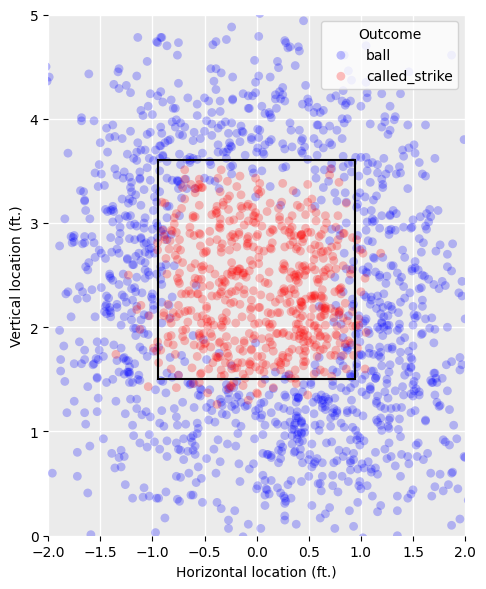

In [3]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.plotting_utils import add_strike_zone

# Further sample only 2000 rows for plotting
sample_n = sc2022_taken.sample(n=2000, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor('#EBEBEB')

colors = {'ball': 'blue', 'called_strike': 'red'}

for outcome in ['ball', 'called_strike']:
    subset = sample_n[sample_n['Outcome'] == outcome]
    ax.scatter(
        subset['plate_x'], 
        subset['plate_z'],
        c=colors[outcome],
        alpha=0.25,
        s=40,
        label=outcome,
        edgecolors='none'
    )

add_strike_zone(ax, facecolor='none')

ax.grid(True, color='white', linewidth=1, zorder=0)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)

ax.set_aspect('equal')

ax.legend(title='Outcome', loc='upper right', frameon=True, framealpha=0.8)

plt.tight_layout()
plt.show()

Many pitches outside the strike zone are called strikes. Catcher framing influences these borderline calls.

#### Compute the probability that a pitch taken in each Statcast zone will be called a strike

In [4]:
zones = sample_n.groupby('zone').agg(
    N=('zone', 'size'),
    right_edge=('plate_x', lambda x: min(1.5, x.max())),
    left_edge=('plate_x', lambda x: max(-1.5, x.min())),
    top_edge=('plate_z', lambda x: min(5, x.quantile(0.95))),
    bottom_edge=('plate_z', lambda x: max(0, x.quantile(0.05))),
    strike_pct=('Outcome', lambda x: (x == 'called_strike').sum() / len(x)),
    plate_x=('plate_x', 'mean'),
    plate_z=('plate_z', 'mean')
).reset_index()

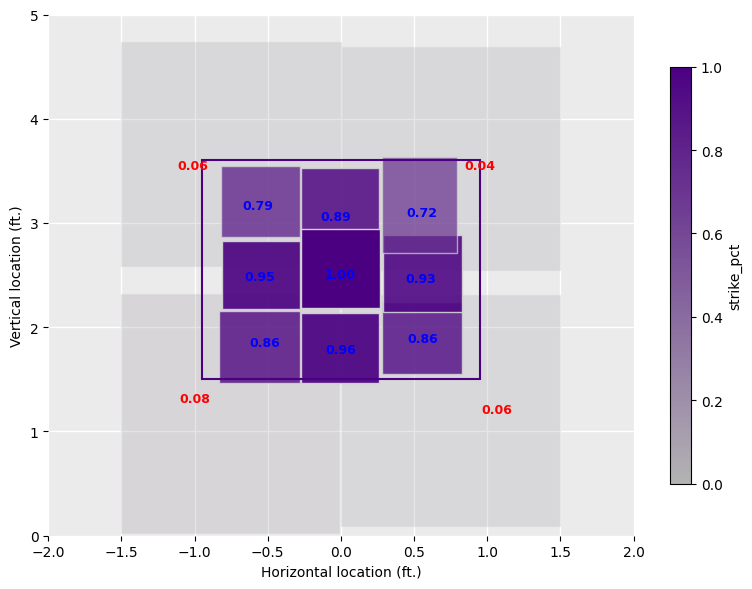

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor('#EBEBEB')

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#B3B3B3', '#4B0082'])
norm = Normalize(vmin=0, vmax=1)

zones_sorted = zones.sort_values('N', ascending=False)

for _, row in zones_sorted.iterrows():
    rect = Rectangle(
        (row['left_edge'], row['bottom_edge']),
        width=row['right_edge'] - row['left_edge'],
        height=row['top_edge'] - row['bottom_edge'],
        facecolor=cmap(norm(row['strike_pct'])),
        edgecolor='lightgray',
        alpha=max(0.3, row['strike_pct']),
        linewidth=1,
        zorder=1
    )
    ax.add_patch(rect)

for _, row in zones.iterrows():
    text_color = 'red' if row['strike_pct'] < 0.5 else 'blue'
    ax.text(
        row['plate_x'], 
        row['plate_z'],
        f"{row['strike_pct']:.2f}",
        ha='center', 
        va='center',
        fontsize=9,
        color=text_color,
        fontweight='bold',
        zorder=3
    )

add_strike_zone(ax, facecolor='none', edgecolor='#4B0082')
ax.patches[-1].set_zorder(2)

ax.grid(True, color='white', linewidth=1, zorder=0)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, label='strike_pct', shrink=0.8)

plt.tight_layout()
plt.show()

- Center of zone: Near-certain strike calls (89-100%)
- Corners: Lower certainty (72-86%) — potential for catcher framing impact
- Outside zone: Strike probability drops to 4-8%

## 7.4 Modeling Called Strike Percentage

In [6]:
from pygam import LogisticGAM, te

taken_clean = taken.dropna(subset=['plate_x', 'plate_z', 'Outcome']).copy()

y = (taken_clean['Outcome'] == 'called_strike').astype(int)
X = taken_clean[['plate_x', 'plate_z']].values

strike_mod = LogisticGAM(te(0, 1)).fit(X, y)

taken_clean['fitted'] = strike_mod.predict_mu(X)

hats = taken_clean.sample(n=min(10000, len(taken_clean)), random_state=42)

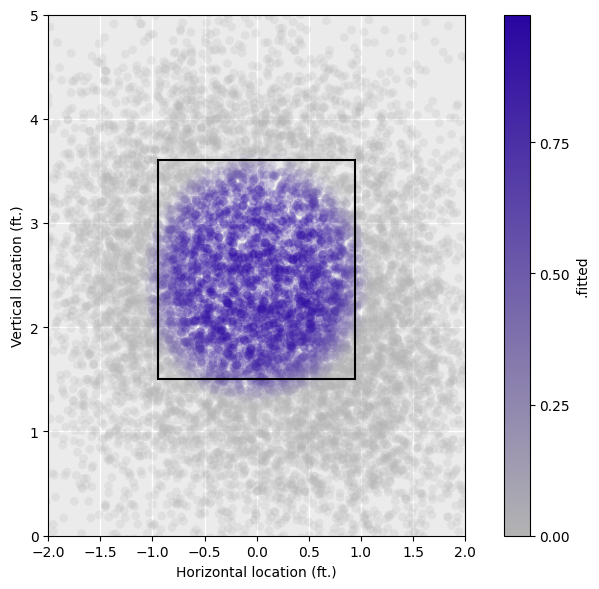

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

hats = taken_clean.sample(n=10000, random_state=42)

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#B3B3B3', "#2905a1"])

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EBEBEB')

scatter = ax.scatter(
    hats['plate_x'], 
    hats['plate_z'],
    c=hats['fitted'],
    cmap=cmap,
    alpha=0.2,
    s=40,
    vmin=0.25,
    vmax=1,
    edgecolors='none'
)

add_strike_zone(ax, facecolor='none')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')

norm = plt.Normalize(vmin=hats['fitted'].min(), vmax=hats['fitted'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='.fitted')
cbar.set_ticks([0, 0.25, 0.50, 0.75])

ax.grid(True, color='white', linewidth=1)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### 7.4.2 Visualizing the estimated surface

In [8]:
import numpy as np

plate_x_range = np.linspace(taken_clean['plate_x'].min(), 
                            taken_clean['plate_x'].max(), 100)
plate_z_range = np.linspace(taken_clean['plate_z'].min(), 
                            taken_clean['plate_z'].max(), 100)

xx, zz = np.meshgrid(plate_x_range, plate_z_range)

X_grid = np.column_stack([xx.ravel(), zz.ravel()])

grid_fitted = strike_mod.predict_mu(X_grid)

fitted_grid = grid_fitted.reshape(xx.shape)

In [9]:
grid_hats = pd.DataFrame({
    'plate_x': X_grid[:, 0],
    'plate_z': X_grid[:, 1],
    'fitted': grid_fitted
})

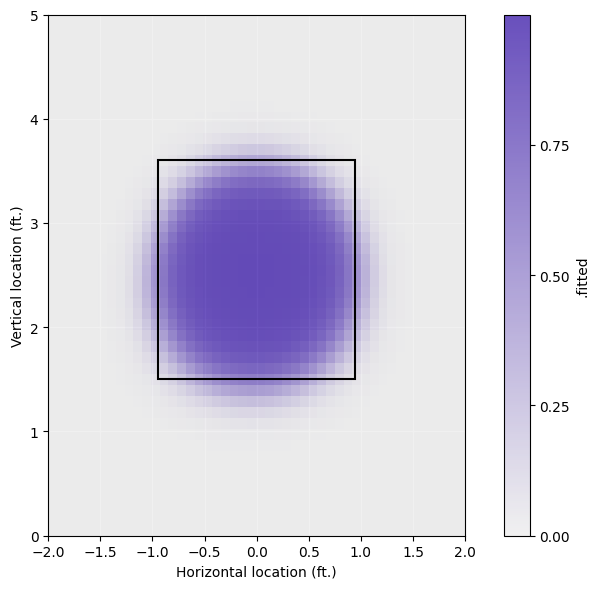

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from src.plotting_utils import add_strike_zone

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#EBEBEB', '#2905a1'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EBEBEB')

tile = ax.pcolormesh(xx, zz, fitted_grid, 
                     cmap=cmap,
                     alpha=0.7,
                     vmin=0, vmax=1,
                     shading='auto')

add_strike_zone(ax, facecolor='none')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')

cbar = plt.colorbar(tile, ax=ax, label='.fitted')
cbar.set_ticks([0, 0.25, 0.50, 0.75])

ax.grid(True, color='white', linewidth=1)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### 7.4.3 Controlling for handedness

In [11]:
from pygam import LogisticGAM, te, f
import numpy as np

taken_clean['p_throws_encoded'] = (taken_clean['p_throws'] == 'R').astype(int)
taken_clean['stand_encoded'] = (taken_clean['stand'] == 'R').astype(int)

y = (taken_clean['Outcome'] == 'called_strike').astype(int)
X = taken_clean[['p_throws_encoded', 'stand_encoded', 'plate_x', 'plate_z']].values

hand_mod = LogisticGAM(f(0) + f(1) + te(2, 3)).fit(X, y)

In [12]:
import pandas as pd
import numpy as np

p_throws_values = taken_clean['p_throws'].unique()
stand_values = taken_clean['stand'].unique()

plate_x_range = np.linspace(taken_clean['plate_x'].min(), 
                            taken_clean['plate_x'].max(), 100)
plate_z_range = np.linspace(taken_clean['plate_z'].min(), 
                            taken_clean['plate_z'].max(), 100)

from itertools import product

grid_combinations = list(product(plate_x_range, plate_z_range, 
                                p_throws_values, stand_values))

hand_grid = pd.DataFrame(grid_combinations, 
                         columns=['plate_x', 'plate_z', 'p_throws', 'stand'])


hand_grid['p_throws_encoded'] = (hand_grid['p_throws'] == 'R').astype(int)
hand_grid['stand_encoded'] = (hand_grid['stand'] == 'R').astype(int)

X_hand_grid = hand_grid[['p_throws_encoded', 'stand_encoded', 'plate_x', 'plate_z']].values
hand_grid['fitted'] = hand_mod.predict_mu(X_hand_grid)


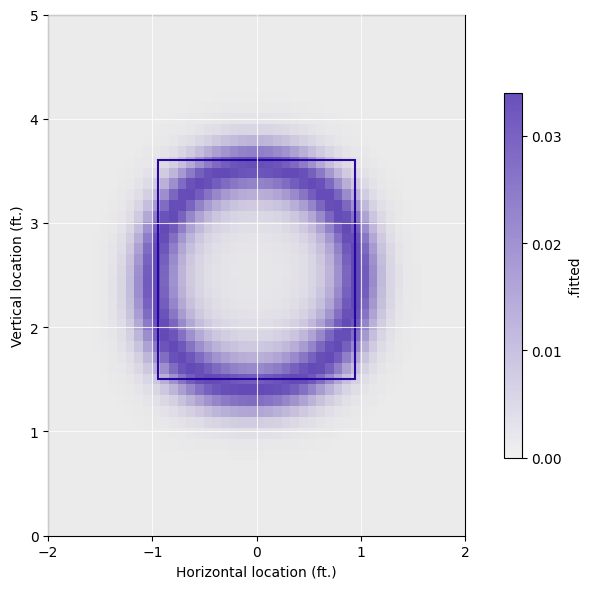

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import numpy as np

diffs = (hand_grid
    .groupby(['plate_x', 'plate_z'])
    .agg(
        N=('fitted', 'size'),
        fitted_sd=('fitted', 'std')
    )
    .reset_index()
)

diffs_sorted = diffs.sort_values(['plate_z', 'plate_x'])
fitted_sd_grid = diffs_sorted['fitted_sd'].values.reshape(100, 100)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EBEBEB')

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#EBEBEB', '#2905A1'])

extent = [plate_x_range.min(), plate_x_range.max(), 
          plate_z_range.min(), plate_z_range.max()]

tile = ax.imshow(fitted_sd_grid, 
                 cmap=cmap,
                 alpha=0.7,
                 extent=extent,
                 origin='lower',
                 aspect='auto',
                 vmin=0,
                 vmax=diffs['fitted_sd'].max())

add_strike_zone(ax, facecolor='none', edgecolor='#2905A1', linewidth=1.5)

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')

cbar = plt.colorbar(tile, ax=ax, label='.fitted', shrink=0.7)
cbar.set_ticks([0, 0.01, 0.02, 0.03])

ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.grid(True, color='white', linewidth=0.8, alpha=0.8)
ax.set_axisbelow(False)

plt.tight_layout()
plt.show()

Handedness differences are largest (up to 2 percentage points) around the strike zone perimeter. In the center, all matchups agree it's a strike. This is where catcher framing matters most.

## 7.5 Modeling Catcher Framing

In [14]:
taken = taken.dropna(subset=['plate_x', 'plate_z']).copy()
taken['strike_prob'] = strike_mod.predict_mu(taken[['plate_x', 'plate_z']].values)

**First mixed model:**

$$\log\frac{p_j}{1-p_j} = \beta_0 + \beta_1 \cdot strike\_prob_j + \alpha_{c(j)}$$

This model can be fit using `BinomialBayesMixedGLM` from `statsmodels` (approximates R's `glmer()` used in the book).

In [15]:
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import numpy as np
import warnings
warnings.filterwarnings('ignore')

y = (taken['Outcome'] == 'called_strike').astype(int)
X_fixed = sm.add_constant(taken['strike_prob'].values)
catcher_dummies = pd.get_dummies(taken['fielder_2'].astype(str), dtype=float)
ident = np.zeros(catcher_dummies.shape[1], dtype=int)

mod_a = BinomialBayesMixedGLM(
    endog=y.values,
    exog=X_fixed,
    exog_vc=catcher_dummies.values,
    ident=ident
)
result_a = mod_a.fit_vb()

In [16]:
#fixed effects
pd.DataFrame({
    '(Intercept)': [result_a.fe_mean[0]],
    'strike_prob': [result_a.fe_mean[1]]
}).round(2)

,(Intercept),strike_prob
0,-4.2,8.15


In [17]:
#random catcher effects
pd.DataFrame({
    'Groups': ['fielder_2'],
    'Name': ['(Intercept)'],
    'Std.Dev.': [np.std(result_a.vc_mean)]
}).round(3)

,Groups,Name,Std.Dev.
0,fielder_2,(Intercept),0.105


`pybaseball` documentation on `chadwick_register` lookup: https://github.com/jldbc/pybaseball/blob/master/docs/chadwick_register.md

In [18]:
from pybaseball import chadwick_register

c_effects = pd.DataFrame({
    'id': catcher_dummies.columns.astype(int),
    'effect': result_a.vc_mean
})

master_id = chadwick_register()
master_id['mlb_name'] = master_id['name_first'].str.title() + ' ' + master_id['name_last'].str.title()
master_id = master_id[['key_mlbam', 'mlb_name']].dropna(subset=['key_mlbam'])
master_id['key_mlbam'] = master_id['key_mlbam'].astype(int)

c_effects = c_effects.merge(
    master_id, 
    left_on='id', 
    right_on='key_mlbam', 
    how='left'
).drop(columns=['key_mlbam'])

c_effects = c_effects.sort_values('effect', ascending=False)

Gathering player lookup table. This may take a moment.


In [19]:
# largest random effect estimates
c_effects.dropna(subset=['mlb_name']).head(6)

,id,effect,mlb_name
67,624431,0.438841,Jose Trevino
74,641680,0.292991,Jonah Heim
132,668939,0.269125,Adley Rutschman
46,596142,0.263435,Gary Sánchez
50,605244,0.250390,Aramis Garcia
33,572287,0.226739,Mike Zunino


In [20]:
# smallest random effect estimates
c_effects.dropna(subset=['mlb_name']).tail(6)

,id,effect,mlb_name
57,608348,-0.189482,Carson Kelly
36,592200,-0.262740,Curt Casali
4,455139,-0.267707,Robinson Chirinos
40,595284,-0.275036,Andrew Knapp
130,668800,-0.355875,Andrew Knizner
134,669004,-0.362757,Mj Melendez


Extending the model to include random effects for both the pitcher and the batter:

$$\log\frac{p_j}{1-p_j} = \beta_0 + \beta_1 \cdot strike\_prob_j + \alpha_{c(j)} + \gamma_{p(j)} + \delta_{b(j)}$$

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

le_catcher = LabelEncoder()
le_pitcher = LabelEncoder()
le_batter = LabelEncoder()

catcher_enc = le_catcher.fit_transform(taken['fielder_2'].astype(str))
pitcher_enc = le_pitcher.fit_transform(taken['pitcher'].astype(str))
batter_enc = le_batter.fit_transform(taken['batter'].astype(str))

def create_sparse_dummies(encoded, n_cats):
    n = len(encoded)
    return sparse.csr_matrix((np.ones(n), (np.arange(n), encoded)), shape=(n, n_cats))

X_catcher = create_sparse_dummies(catcher_enc, len(le_catcher.classes_))
X_pitcher = create_sparse_dummies(pitcher_enc, len(le_pitcher.classes_))
X_batter = create_sparse_dummies(batter_enc, len(le_batter.classes_))
X_strike = taken['strike_prob'].values.reshape(-1, 1)

X_full = sparse.hstack([X_strike, X_catcher, X_pitcher, X_batter])

mod_b = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
mod_b.fit(X_full, y.values)

n_c = len(le_catcher.classes_)
n_p = len(le_pitcher.classes_)
coef_catcher = mod_b.coef_[0, 1:1+n_c]
coef_pitcher = mod_b.coef_[0, 1+n_c:1+n_c+n_p]
coef_batter = mod_b.coef_[0, 1+n_c+n_p:]

In [22]:
pd.DataFrame({
    'Groups': ['pitcher', 'batter', 'fielder_2'],
    'Name': ['(Intercept)'] * 3,
    'Std.Dev.': [np.std(coef_pitcher), np.std(coef_batter), np.std(coef_catcher)]
}).round(3)

,Groups,Name,Std.Dev.
0,pitcher,(Intercept),0.420
1,batter,(Intercept),0.369
2,fielder_2,(Intercept),0.331


These results suggest that framing has less influence than pitcher/batter identity, but is still measurable and valuable.


The largest standard deviations are $s_p$ and $s_b$ which indicate that called strikes are most influenced by the identities of the pitcher and batter, followed by the identity of the catcher.

In [23]:
c_effects = pd.DataFrame({
    'id': le_catcher.classes_.astype(int),
    'effect': coef_catcher
})

c_effects = c_effects.merge(
    master_id, 
    left_on='id', 
    right_on='key_mlbam', 
    how='left'
).drop(columns=['key_mlbam'])

c_effects = c_effects.sort_values('effect', ascending=False)

In [24]:
c_effects.dropna(subset=['mlb_name']).head(6)

,id,effect,mlb_name
121,665856,0.794726,Jair Camargo
50,605244,0.719109,Aramis Garcia
33,572287,0.675085,Mike Zunino
6,492802,0.666313,Juan Graterol
142,671056,0.554270,Iván Herrera
118,664926,0.541640,Nick Dini


In [25]:
c_effects.dropna(subset=['mlb_name']).tail(6)

,id,effect,mlb_name
84,645305,-0.556404,Ali Sánchez
36,592200,-0.670684,Curt Casali
76,642020,-0.718583,Chuckie Robinson
71,641470,-0.769457,Zack Collins
40,595284,-1.107444,Andrew Knapp
115,664848,-1.178014,Donny Sands
